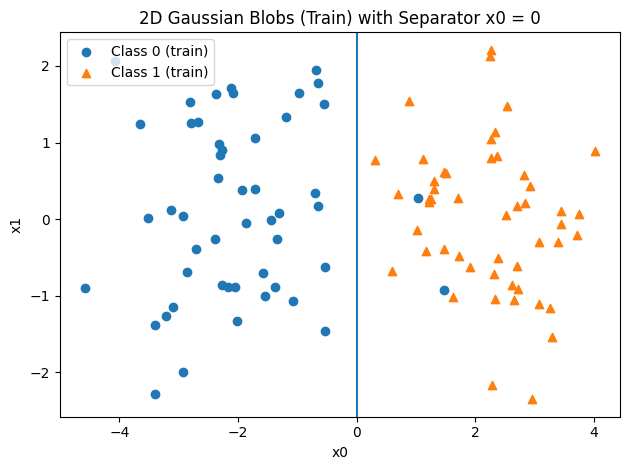

,d,train_sep_acc_by_x0>0,test_sep_acc_by_x0>0
0,2,0.98,0.96
1,10,0.98,0.97


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

# Reproducibility
rng = np.random.default_rng(42)

def make_separable_gaussian_blobs(
    n_train=100, n_test=100, d=2, mean_sep=4.0, sigma=1.0, seed=42
):

    rng = np.random.default_rng(seed)
    # Means: +mean_sep/2 and -mean_sep/2 along first axis; zeros elsewhere
    mu_pos = np.zeros(d); mu_pos[0] = +mean_sep / 2
    mu_neg = np.zeros(d); mu_neg[0] = -mean_sep / 2
    cov = (sigma ** 2) * np.eye(d)

    # Sample
    n_train_half = n_train // 2
    n_test_half = n_test // 2

    X_train_pos = rng.multivariate_normal(mu_pos, cov, size=n_train_half)
    X_train_neg = rng.multivariate_normal(mu_neg, cov, size=n_train - n_train_half)
    X_test_pos  = rng.multivariate_normal(mu_pos, cov, size=n_test_half)
    X_test_neg  = rng.multivariate_normal(mu_neg, cov, size=n_test - n_test_half)

    X_train = np.vstack([X_train_pos, X_train_neg])
    y_train = np.hstack([np.ones(len(X_train_pos), dtype=int), np.zeros(len(X_train_neg), dtype=int)])
    X_test  = np.vstack([X_test_pos, X_test_neg])
    y_test  = np.hstack([np.ones(len(X_test_pos), dtype=int),  np.zeros(len(X_test_neg), dtype=int)])

    # Shuffle
    train_perm = rng.permutation(len(X_train))
    test_perm = rng.permutation(len(X_test))
    X_train, y_train = X_train[train_perm], y_train[train_perm]
    X_test, y_test = X_test[test_perm], y_test[test_perm]

    # Theoretical separator is sign of x0 (with threshold 0)
    # Compute empirical separability stats
    preds_train = (X_train[:, 0] > 0).astype(int)
    preds_test = (X_test[:, 0] > 0).astype(int)
    train_sep_acc = (preds_train == y_train).mean()
    test_sep_acc = (preds_test == y_test).mean()

    return (X_train, y_train, X_test, y_test, train_sep_acc, test_sep_acc, mu_pos, mu_neg, sigma)

# Create BOTH 2D (easy to visualize) and 10D (theory-style) datasets
datasets = {}
for d in (2, 10):
    Xtr, ytr, Xte, yte, acc_tr, acc_te, mu_pos, mu_neg, sigma = make_separable_gaussian_blobs(
        n_train=100, n_test=100, d=d, mean_sep=4.0, sigma=1.0, seed=42 + d
    )
    datasets[d] = dict(
        X_train=Xtr, y_train=ytr, X_test=Xte, y_test=yte,
        sep_acc_train=acc_tr, sep_acc_test=acc_te, mu_pos=mu_pos, mu_neg=mu_neg, sigma=sigma
    )

# Save to disk (NPZ + CSVs)
out_dir = Path(".")
npz_path = out_dir / "synthetic_separable_blobs.npz"
np.savez_compressed(
    npz_path,
    X_train_2d=datasets[2]["X_train"], y_train_2d=datasets[2]["y_train"],
    X_test_2d=datasets[2]["X_test"], y_test_2d=datasets[2]["y_test"],
    X_train_10d=datasets[10]["X_train"], y_train_10d=datasets[10]["y_train"],
    X_test_10d=datasets[10]["X_test"], y_test_10d=datasets[10]["y_test"],
)

# CSVs
def save_csv(X, y, path_prefix):
    cols = [f"x{i}" for i in range(X.shape[1])]
    df = pd.DataFrame(X, columns=cols)
    df["y"] = y
    df.to_csv(path_prefix, index=False)
    return df

df_train_2d = save_csv(datasets[2]["X_train"], datasets[2]["y_train"], out_dir / "train_2d.csv")
df_test_2d  = save_csv(datasets[2]["X_test"],  datasets[2]["y_test"],  out_dir / "test_2d.csv")
df_train_10d = save_csv(datasets[10]["X_train"], datasets[10]["y_train"], out_dir / "train_10d.csv")
df_test_10d  = save_csv(datasets[10]["X_test"],  datasets[10]["y_test"],  out_dir / "test_10d.csv")

# Plot 2D dataset
plt.figure()
X = datasets[2]["X_train"]
y = datasets[2]["y_train"]
plt.scatter(X[y==0, 0], X[y==0, 1], marker="o", label="Class 0 (train)")
plt.scatter(X[y==1, 0], X[y==1, 1], marker="^", label="Class 1 (train)")

# Decision boundary x0 = 0
ymin, ymax = plt.ylim()
plt.plot([0, 0], [ymin, ymax])
plt.ylim(ymin, ymax)
plt.title("2D Gaussian Blobs (Train) with Separator x0 = 0")
plt.xlabel("x0")
plt.ylabel("x1")
plt.legend()
plt.tight_layout()

plot_path = out_dir / "train_2d_scatter.png"
plt.savefig(plot_path, dpi=200)
plt.show()

# Print quick stats
stats = pd.DataFrame([
    {"d": 2, "train_sep_acc_by_x0>0": datasets[2]["sep_acc_train"], "test_sep_acc_by_x0>0": datasets[2]["sep_acc_test"]},
    {"d": 10, "train_sep_acc_by_x0>0": datasets[10]["sep_acc_train"], "test_sep_acc_by_x0>0": datasets[10]["sep_acc_test"]},
])
stats

In [ ]:
def make_noisy_separable_gaussian_blobs(
    n_train=500,
    n_test=500,
    d=20,
    mean_sep=2.0,
    sigma=1.5,
    noise_rate=0.1,
    seed=42
):
    rng = np.random.default_rng(seed)

    # Means separated along first coordinate
    mu_pos = np.zeros(d); mu_pos[0] = +mean_sep / 2
    mu_neg = np.zeros(d); mu_neg[0] = -mean_sep / 2
    cov = (sigma ** 2) * np.eye(d)

    # Generate clean data
    X_train = np.vstack([
        rng.multivariate_normal(mu_pos, cov, size=n_train // 2),
        rng.multivariate_normal(mu_neg, cov, size=n_train - n_train // 2),
    ])
    y_train = np.hstack([
        np.ones(n_train // 2),
        -np.ones(n_train - n_train // 2),
    ])

    X_test = np.vstack([
        rng.multivariate_normal(mu_pos, cov, size=n_test // 2),
        rng.multivariate_normal(mu_neg, cov, size=n_test - n_test // 2),
    ])
    y_test = np.hstack([
        np.ones(n_test // 2),
        -np.ones(n_test - n_test // 2),
    ])

    # Shuffle
    perm_tr = rng.permutation(len(X_train))
    perm_te = rng.permutation(len(X_test))
    X_train, y_train = X_train[perm_tr], y_train[perm_tr]
    X_test, y_test = X_test[perm_te], y_test[perm_te]

    # Add label noise to TRAIN ONLY
    n_flip = int(noise_rate * n_train)
    flip_idx = rng.choice(n_train, size=n_flip, replace=False)
    y_train[flip_idx] *= -1

    return (
        torch.tensor(X_train, dtype=torch.float32),
        torch.tensor(y_train, dtype=torch.float32),
        torch.tensor(X_test, dtype=torch.float32),
        torch.tensor(y_test, dtype=torch.float32),
    )


In [ ]:
# Step 2: Baseline Training Run (self-contained)
# Two-layer ReLU network, full-batch GD, medium learning rate

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

def make_separable_gaussian_blobs(n_train=100, n_test=100, d=2, mean_sep=4.0, sigma=1.0, seed=42):
    rng = np.random.default_rng(seed)
    mu_pos = np.zeros(d); mu_pos[0] = +mean_sep / 2
    mu_neg = np.zeros(d); mu_neg[0] = -mean_sep / 2
    cov = (sigma ** 2) * np.eye(d)

    n_train_half = n_train // 2
    n_test_half = n_test // 2

    X_train = np.vstack([
        rng.multivariate_normal(mu_pos, cov, size=n_train_half),
        rng.multivariate_normal(mu_neg, cov, size=n_train - n_train_half),
    ])
    y_train = np.hstack([
        np.ones(n_train_half),
        -np.ones(n_train - n_train_half),
    ])

    X_test = np.vstack([
        rng.multivariate_normal(mu_pos, cov, size=n_test_half),
        rng.multivariate_normal(mu_neg, cov, size=n_test - n_test_half),
    ])
    y_test = np.hstack([
        np.ones(n_test_half),
        -np.ones(n_test - n_test_half),
    ])

    perm_tr = rng.permutation(len(X_train))
    perm_te = rng.permutation(len(X_test))
    return (
        torch.tensor(X_train[perm_tr], dtype=torch.float32),
        torch.tensor(y_train[perm_tr], dtype=torch.float32),
        torch.tensor(X_test[perm_te], dtype=torch.float32),
        torch.tensor(y_test[perm_te], dtype=torch.float32),
    )

X_train, y_train, X_test, y_test = make_separable_gaussian_blobs()
#X_train, y_train, X_test, y_test = make_noisy_separable_gaussian_blobs()

class TwoLayerReLU(nn.Module):
    def __init__(self, d, width):
        super().__init__()
        self.fc1 = nn.Linear(d, width, bias=False)
        self.fc2 = nn.Linear(width, 1, bias=False)

    def forward(self, x):
        return self.fc2(torch.relu(self.fc1(x))).squeeze()

model = TwoLayerReLU(d=2, width=200)

lr = 0.01            # medium learning rate
epochs = 2000        # train to near-zero loss
criterion = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=lr)

losses = []
margins = []

for epoch in range(epochs):
    optimizer.zero_grad()
    outputs = model(X_train)
    loss = criterion(outputs, y_train)
    loss.backward()
    optimizer.step()

    losses.append(loss.item())

    with torch.no_grad():
        margin = torch.min(y_train * model(X_train)).item()
        margins.append(margin)

with torch.no_grad():
    test_outputs = model(X_test)
    test_preds = torch.sign(test_outputs)
    test_acc = (test_preds == y_test).float().mean().item()

print(f"Final training loss: {losses[-1]:.4e}")
print(f"Final margin: {margins[-1]:.4f}")
print(f"Final test accuracy: {test_acc:.4f}")

# --------------------
# Plots
# --------------------
plt.figure()
plt.plot(losses)
plt.xlabel("Epoch")
plt.ylabel("Training Loss")
plt.title("Baseline: Training Loss vs Epochs")
plt.tight_layout()
plt.show()

plt.figure()
plt.plot(margins)
plt.xlabel("Epoch")
plt.ylabel("Margin")
plt.title("Baseline: Margin Growth vs Epochs")
plt.tight_layout()
plt.show()


RuntimeError: mat1 and mat2 shapes cannot be multiplied (500x20 and 2x200)

Small LR (0.001): final margin = -0.1029, test acc = 0.980
Medium LR (0.01): final margin = -0.0782, test acc = 0.970
Large LR (0.05): final margin = -0.1013, test acc = 0.970


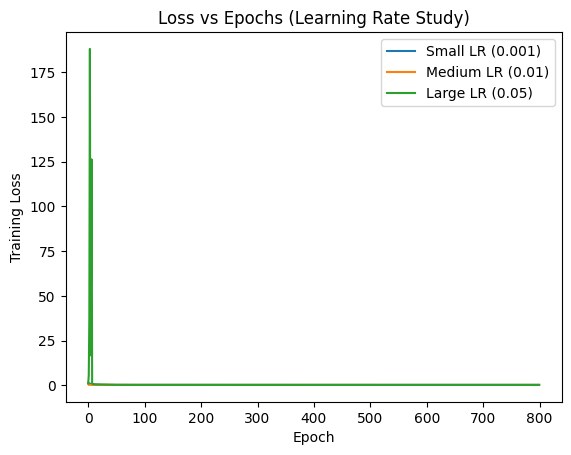

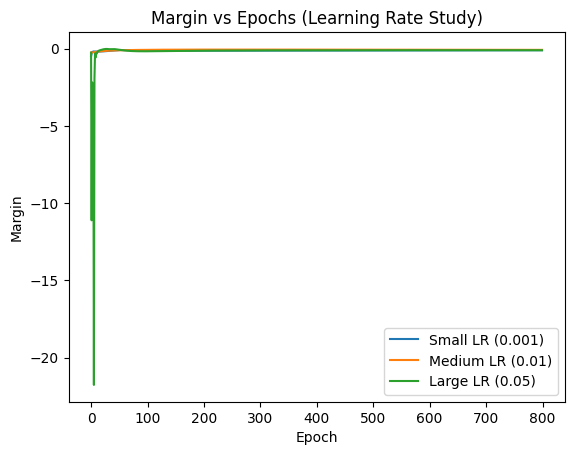

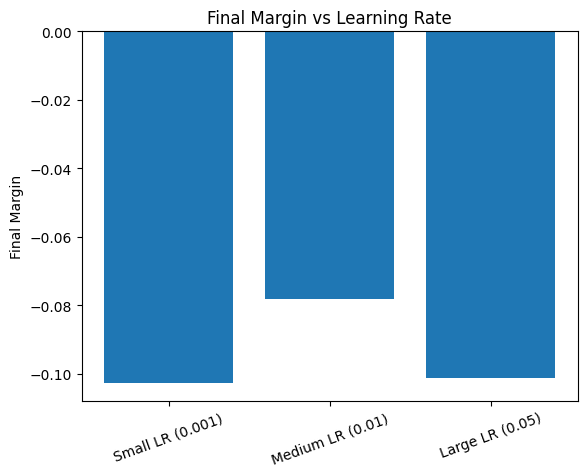

In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

def make_separable_gaussian_blobs(n_train=100, n_test=100, d=2, mean_sep=4.0, sigma=1.0, seed=42):
    rng = np.random.default_rng(seed)
    mu_pos = np.zeros(d); mu_pos[0] = +mean_sep / 2
    mu_neg = np.zeros(d); mu_neg[0] = -mean_sep / 2
    cov = (sigma ** 2) * np.eye(d)

    X_train = np.vstack([
        rng.multivariate_normal(mu_pos, cov, size=n_train // 2),
        rng.multivariate_normal(mu_neg, cov, size=n_train - n_train // 2),
    ])
    y_train = np.hstack([np.ones(n_train // 2), -np.ones(n_train - n_train // 2)])

    X_test = np.vstack([
        rng.multivariate_normal(mu_pos, cov, size=n_test // 2),
        rng.multivariate_normal(mu_neg, cov, size=n_test - n_test // 2),
    ])
    y_test = np.hstack([np.ones(n_test // 2), -np.ones(n_test - n_test // 2)])

    perm_tr = rng.permutation(len(X_train))
    perm_te = rng.permutation(len(X_test))

    return (
        torch.tensor(X_train[perm_tr], dtype=torch.float32),
        torch.tensor(y_train[perm_tr], dtype=torch.float32),
        torch.tensor(X_test[perm_te], dtype=torch.float32),
        torch.tensor(y_test[perm_te], dtype=torch.float32),
    )

X_train, y_train, X_test, y_test = make_separable_gaussian_blobs()
#X_train, y_train, X_test, y_test = make_noisy_separable_gaussian_blobs()

class TwoLayerReLU(nn.Module):
    def __init__(self, d, width):
        super().__init__()
        self.fc1 = nn.Linear(d, width, bias=False)
        self.fc2 = nn.Linear(width, 1, bias=False)

    def forward(self, x):
        return self.fc2(torch.relu(self.fc1(x))).squeeze()


def train_model(lr, epochs=800):
    model = TwoLayerReLU(d=2, width=200)
    #model = TwoLayerReLU(d=X_train.shape[1], width=200)
    optimizer = optim.SGD(model.parameters(), lr=lr)
    criterion = nn.MSELoss()

    losses, margins = [], []

    for _ in range(epochs):
        optimizer.zero_grad()
        out = model(X_train)
        loss = criterion(out, y_train)
        loss.backward()
        optimizer.step()

        losses.append(loss.item())
        with torch.no_grad():
            margins.append(torch.min(y_train * model(X_train)).item())

    with torch.no_grad():
        acc = (torch.sign(model(X_test)) == y_test).float().mean().item()

    return losses, margins, acc

lrs = {
    "Small LR (0.001)": 0.001,
    "Medium LR (0.01)": 0.01,
    "Large LR (0.05)": 0.05,
}

results = {}
for name, lr in lrs.items():
    losses, margins, acc = train_model(lr)
    results[name] = (losses, margins, acc)
    print(f"{name}: final margin = {margins[-1]:.4f}, test acc = {acc:.3f}")

plt.figure()
for name, (losses, _, _) in results.items():
    plt.plot(losses, label=name)
plt.xlabel("Epoch")
plt.ylabel("Training Loss")
plt.title("Loss vs Epochs (Learning Rate Study)")
plt.legend()
plt.show()

plt.figure()
for name, (_, margins, _) in results.items():
    plt.plot(margins, label=name)
plt.xlabel("Epoch")
plt.ylabel("Margin")
plt.title("Margin vs Epochs (Learning Rate Study)")
plt.legend()
plt.show()

plt.figure()
names = list(results.keys())
final_margins = [results[n][1][-1] for n in names]
plt.bar(names, final_margins)
plt.ylabel("Final Margin")
plt.title("Final Margin vs Learning Rate")
plt.xticks(rotation=20)
plt.show()


Small LR (0.001): final margin = -1.2655, test acc = 0.686
Medium LR (0.01): final margin = -1.1575, test acc = 0.644
Large LR (0.02): final margin = -0.6515, test acc = 0.650


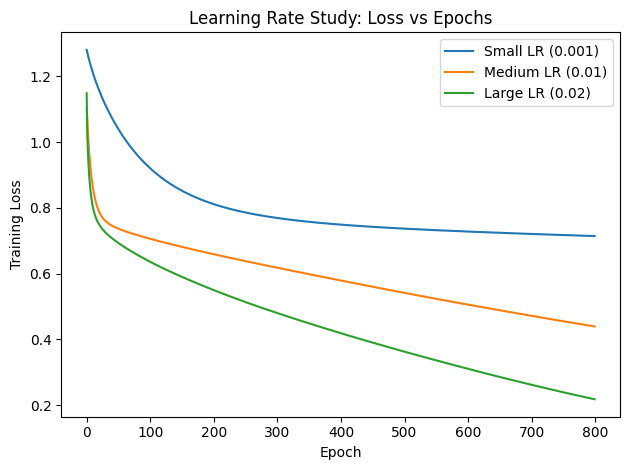

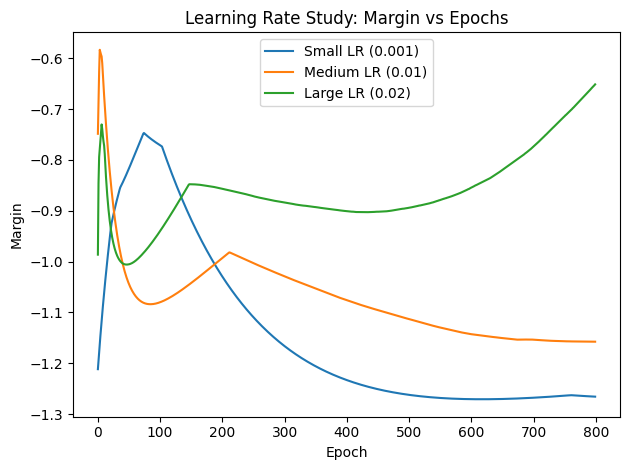

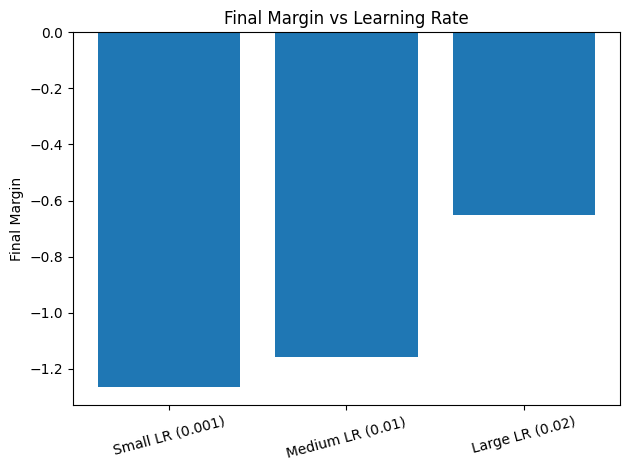

In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

def make_separable_gaussian_blobs(n_train=100, n_test=100, d=2, mean_sep=4.0, sigma=1.0, seed=42):
    rng = np.random.default_rng(seed)
    mu_pos = np.zeros(d); mu_pos[0] = +mean_sep / 2
    mu_neg = np.zeros(d); mu_neg[0] = -mean_sep / 2
    cov = (sigma ** 2) * np.eye(d)

    X_train = np.vstack([
        rng.multivariate_normal(mu_pos, cov, size=n_train // 2),
        rng.multivariate_normal(mu_neg, cov, size=n_train - n_train // 2),
    ])
    y_train = np.hstack([
        np.ones(n_train // 2),
        -np.ones(n_train - n_train // 2),
    ])

    X_test = np.vstack([
        rng.multivariate_normal(mu_pos, cov, size=n_test // 2),
        rng.multivariate_normal(mu_neg, cov, size=n_test - n_test // 2),
    ])
    y_test = np.hstack([
        np.ones(n_test // 2),
        -np.ones(n_test - n_test // 2),
    ])

    perm_tr = rng.permutation(len(X_train))
    perm_te = rng.permutation(len(X_test))

    return (
        torch.tensor(X_train[perm_tr], dtype=torch.float32),
        torch.tensor(y_train[perm_tr], dtype=torch.float32),
        torch.tensor(X_test[perm_te], dtype=torch.float32),
        torch.tensor(y_test[perm_te], dtype=torch.float32),
    )

#X_train, y_train, X_test, y_test = make_separable_gaussian_blobs()
X_train, y_train, X_test, y_test = make_noisy_separable_gaussian_blobs()

class TwoLayerReLU(nn.Module):
    def __init__(self, d, width):
        super().__init__()
        self.fc1 = nn.Linear(d, width, bias=False)
        self.fc2 = nn.Linear(width, 1, bias=False)

    def forward(self, x):
        return self.fc2(torch.relu(self.fc1(x))).squeeze()


def train_model(lr, epochs=800):
    #model = TwoLayerReLU(d=2, width=200)
    model = TwoLayerReLU(d=X_train.shape[1], width=200)
    optimizer = optim.SGD(model.parameters(), lr=lr)
    criterion = nn.MSELoss()

    losses = []
    margins = []

    for _ in range(epochs):
        optimizer.zero_grad()
        out = model(X_train)
        loss = criterion(out, y_train)
        loss.backward()
        optimizer.step()

        losses.append(loss.item())
        with torch.no_grad():
            margins.append(torch.min(y_train * model(X_train)).item())

    with torch.no_grad():
        test_acc = (torch.sign(model(X_test)) == y_test).float().mean().item()

    return losses, margins, test_acc

learning_rates = {
    "Small LR (0.001)": 0.001,
    "Medium LR (0.01)": 0.01,
    "Large LR (0.02)": 0.02,
}

results = {}

for label, lr in learning_rates.items():
    losses, margins, acc = train_model(lr)
    results[label] = {
        "losses": losses,
        "margins": margins,
        "final_margin": margins[-1],
        "test_acc": acc,
    }
    print(f"{label}: final margin = {margins[-1]:.4f}, test acc = {acc:.3f}")

plt.figure()
for label, res in results.items():
    plt.plot(res["losses"], label=label)
plt.xlabel("Epoch")
plt.ylabel("Training Loss")
plt.title("Learning Rate Study: Loss vs Epochs")
plt.legend()
plt.tight_layout()
plt.show()

plt.figure()
for label, res in results.items():
    plt.plot(res["margins"], label=label)
plt.xlabel("Epoch")
plt.ylabel("Margin")
plt.title("Learning Rate Study: Margin vs Epochs")
plt.legend()
plt.tight_layout()
plt.show()

plt.figure()
labels = list(results.keys())
final_margins = [results[l]["final_margin"] for l in labels]
plt.bar(labels, final_margins)
plt.ylabel("Final Margin")
plt.title("Final Margin vs Learning Rate")
plt.xticks(rotation=15)
plt.tight_layout()
plt.show()


Full batch (100): final train acc=0.996, test acc=0.606, gap=+0.390, final margin=-0.1230, final loss=0.0670
Medium batch (20): final train acc=1.000, test acc=0.582, gap=+0.418, final margin=0.9950, final loss=0.0000
Small batch (5): final train acc=1.000, test acc=0.580, gap=+0.420, final margin=1.0000, final loss=0.0000


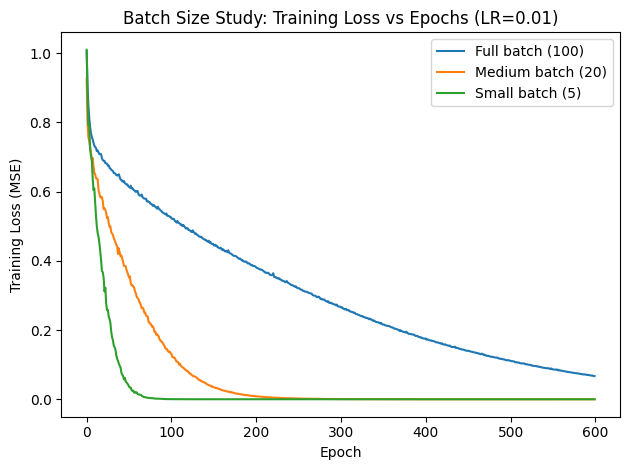

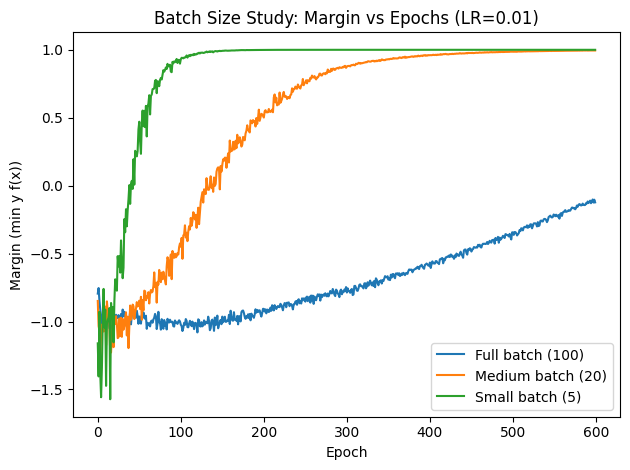

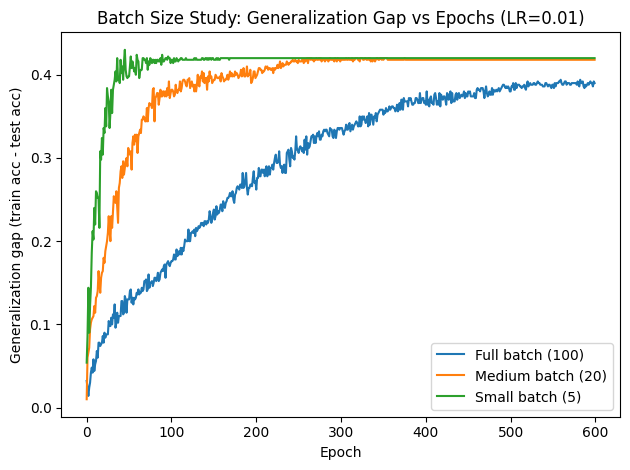

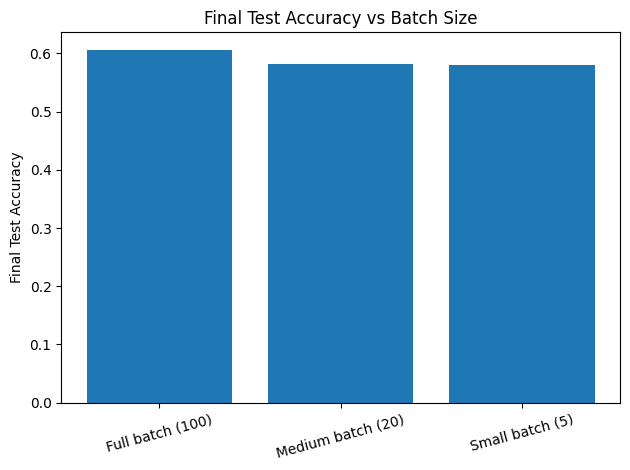

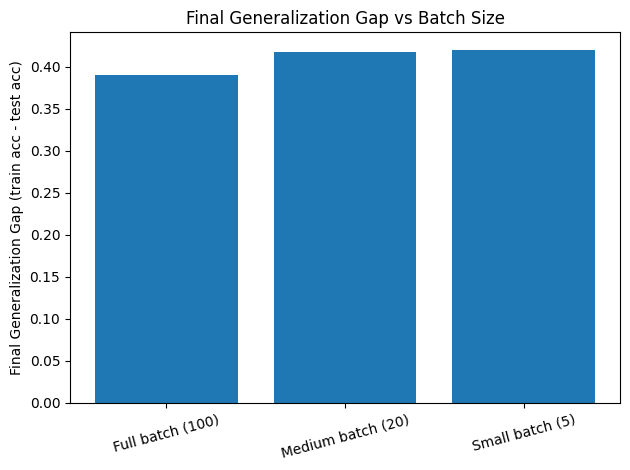

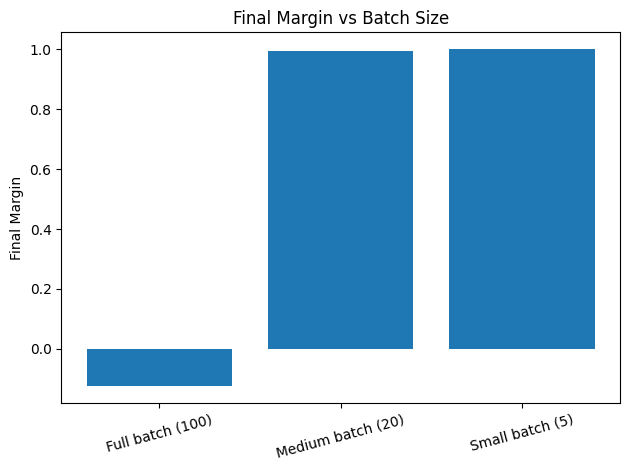

In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt

def make_separable_gaussian_blobs(n_train=100, n_test=100, d=2, mean_sep=4.0, sigma=1.0, seed=42):
    rng = np.random.default_rng(seed)
    mu_pos = np.zeros(d); mu_pos[0] = +mean_sep / 2
    mu_neg = np.zeros(d); mu_neg[0] = -mean_sep / 2
    cov = (sigma ** 2) * np.eye(d)

    X_train = np.vstack([
        rng.multivariate_normal(mu_pos, cov, size=n_train // 2),
        rng.multivariate_normal(mu_neg, cov, size=n_train - n_train // 2),
    ])
    y_train = np.hstack([np.ones(n_train // 2), -np.ones(n_train - n_train // 2)])

    X_test = np.vstack([
        rng.multivariate_normal(mu_pos, cov, size=n_test // 2),
        rng.multivariate_normal(mu_neg, cov, size=n_test - n_test // 2),
    ])
    y_test = np.hstack([np.ones(n_test // 2), -np.ones(n_test - n_test // 2)])

    perm_tr = rng.permutation(len(X_train))
    perm_te = rng.permutation(len(X_test))
    return (
        torch.tensor(X_train[perm_tr], dtype=torch.float32),
        torch.tensor(y_train[perm_tr], dtype=torch.float32),
        torch.tensor(X_test[perm_te], dtype=torch.float32),
        torch.tensor(y_test[perm_te], dtype=torch.float32),
    )

#X_train, y_train, X_test, y_test = make_separable_gaussian_blobs()
X_train, y_train, X_test, y_test = make_noisy_separable_gaussian_blobs()


class TwoLayerReLU(nn.Module):
    def __init__(self, d, width):
        super().__init__()
        self.fc1 = nn.Linear(d, width, bias=False)
        self.fc2 = nn.Linear(width, 1, bias=False)

    def forward(self, x):
        return self.fc2(torch.relu(self.fc1(x))).squeeze()

def train_with_batch_size(batch_size, lr=0.01, epochs=600, width=200, seed=0):
    torch.manual_seed(seed)
    #model = TwoLayerReLU(d=2, width=width)
    model = TwoLayerReLU(d=X_train.shape[1], width=200)
    optimizer = optim.SGD(model.parameters(), lr=lr)
    criterion = nn.MSELoss()

    train_ds = TensorDataset(X_train, y_train)
    loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, drop_last=False)

    train_losses = []
    train_margins = []
    train_accs = []
    test_accs = []
    gen_gaps = []  # train_acc - test_acc

    for _ in range(epochs):
        # one epoch over (shuffled) mini-batches
        model.train()
        epoch_loss = 0.0
        n = 0
        for xb, yb in loader:
            optimizer.zero_grad()
            out = model(xb)
            loss = criterion(out, yb)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item() * len(xb)
            n += len(xb)
        train_losses.append(epoch_loss / n)

        # diagnostics on full train/test
        model.eval()
        with torch.no_grad():
            f_train = model(X_train)
            f_test = model(X_test)

            margin = torch.min(y_train * f_train).item()
            train_margins.append(margin)

            train_acc = (torch.sign(f_train) == y_train).float().mean().item()
            test_acc = (torch.sign(f_test) == y_test).float().mean().item()

            train_accs.append(train_acc)
            test_accs.append(test_acc)
            gen_gaps.append(train_acc - test_acc)

    return {
        "train_loss": train_losses,
        "margin": train_margins,
        "train_acc": train_accs,
        "test_acc": test_accs,
        "gen_gap": gen_gaps,
        "final_train_acc": train_accs[-1],
        "final_test_acc": test_accs[-1],
        "final_gap": gen_gaps[-1],
        "final_margin": train_margins[-1],
        "final_loss": train_losses[-1],
    }

lr = 0.01
epochs = 600
batch_sizes = {
    "Full batch (100)": 100,
    "Medium batch (20)": 20,
    "Small batch (5)": 5,
}

results = {}
for label, bs in batch_sizes.items():
    res = train_with_batch_size(bs, lr=lr, epochs=epochs, seed=123)
    results[label] = res
    print(f"{label}: final train acc={res['final_train_acc']:.3f}, test acc={res['final_test_acc']:.3f}, "
          f"gap={res['final_gap']:+.3f}, final margin={res['final_margin']:.4f}, final loss={res['final_loss']:.4f}")


plt.figure()
for label, res in results.items():
    plt.plot(res["train_loss"], label=label)
plt.xlabel("Epoch")
plt.ylabel("Training Loss (MSE)")
plt.title(f"Batch Size Study: Training Loss vs Epochs (LR={lr})")
plt.legend()
plt.tight_layout()
plt.show()

plt.figure()
for label, res in results.items():
    plt.plot(res["margin"], label=label)
plt.xlabel("Epoch")
plt.ylabel("Margin (min y f(x))")
plt.title(f"Batch Size Study: Margin vs Epochs (LR={lr})")
plt.legend()
plt.tight_layout()
plt.show()


plt.figure()
for label, res in results.items():
    plt.plot(res["gen_gap"], label=label)
plt.xlabel("Epoch")
plt.ylabel("Generalization gap (train acc - test acc)")
plt.title(f"Batch Size Study: Generalization Gap vs Epochs (LR={lr})")
plt.legend()
plt.tight_layout()
plt.show()

labels = list(results.keys())
final_test_accs = [results[l]["final_test_acc"] for l in labels]
final_gaps = [results[l]["final_gap"] for l in labels]
final_margins = [results[l]["final_margin"] for l in labels]

plt.figure()
plt.bar(labels, final_test_accs)
plt.ylabel("Final Test Accuracy")
plt.title("Final Test Accuracy vs Batch Size")
plt.xticks(rotation=15)
plt.tight_layout()
plt.show()

plt.figure()
plt.bar(labels, final_gaps)
plt.ylabel("Final Generalization Gap (train acc - test acc)")
plt.title("Final Generalization Gap vs Batch Size")
plt.xticks(rotation=15)
plt.tight_layout()
plt.show()

plt.figure()
plt.bar(labels, final_margins)
plt.ylabel("Final Margin")
plt.title("Final Margin vs Batch Size")
plt.xticks(rotation=15)
plt.tight_layout()
plt.show()


EARLY STOP
 epoch=300, norm=8.177, margin=-1.037, test acc=0.678

LATE STOP
 epoch=1999, norm=8.775, margin=-0.632, test acc=0.616


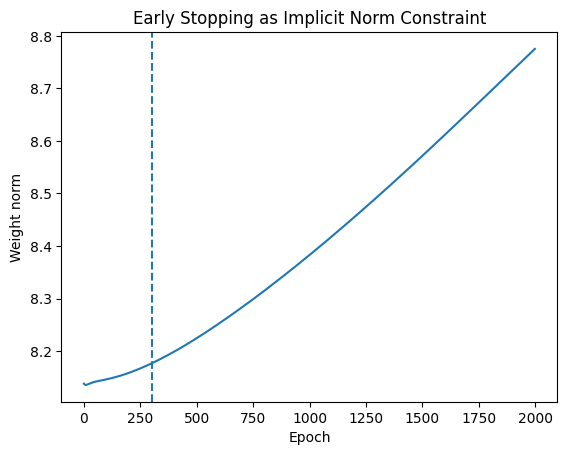

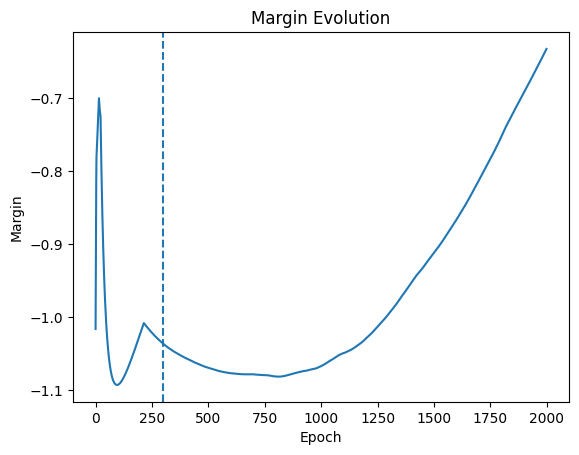

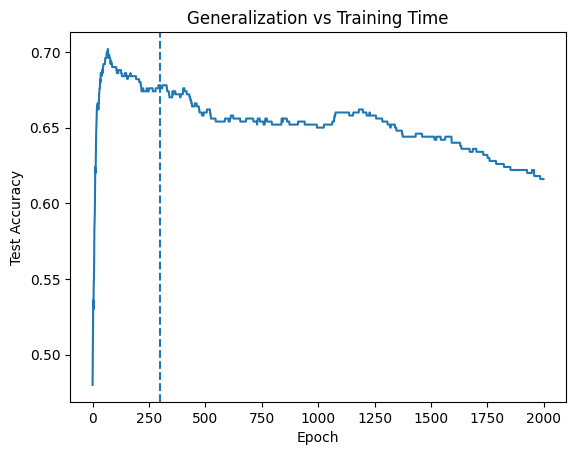

In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

def make_noisy_separable_gaussian_blobs(
    n_train=500, n_test=500, d=20, mean_sep=2.0, sigma=1.5, noise_rate=0.1, seed=42
):
    rng = np.random.default_rng(seed)
    mu_pos = np.zeros(d); mu_pos[0] = +mean_sep / 2
    mu_neg = np.zeros(d); mu_neg[0] = -mean_sep / 2
    cov = (sigma ** 2) * np.eye(d)

    X_train = np.vstack([
        rng.multivariate_normal(mu_pos, cov, size=n_train // 2),
        rng.multivariate_normal(mu_neg, cov, size=n_train - n_train // 2),
    ])
    y_train = np.hstack([np.ones(n_train // 2), -np.ones(n_train - n_train // 2)])

    X_test = np.vstack([
        rng.multivariate_normal(mu_pos, cov, size=n_test // 2),
        rng.multivariate_normal(mu_neg, cov, size=n_test - n_test // 2),
    ])
    y_test = np.hstack([np.ones(n_test // 2), -np.ones(n_test - n_test // 2)])

    perm_tr = rng.permutation(len(X_train))
    perm_te = rng.permutation(len(X_test))
    X_train, y_train = X_train[perm_tr], y_train[perm_tr]
    X_test, y_test = X_test[perm_te], y_test[perm_te]

    n_flip = int(noise_rate * n_train)
    flip_idx = rng.choice(n_train, size=n_flip, replace=False)
    y_train[flip_idx] *= -1

    return (
        torch.tensor(X_train, dtype=torch.float32),
        torch.tensor(y_train, dtype=torch.float32),
        torch.tensor(X_test, dtype=torch.float32),
        torch.tensor(y_test, dtype=torch.float32),
    )

X_train, y_train, X_test, y_test = make_noisy_separable_gaussian_blobs()

class TwoLayerReLU(nn.Module):
    def __init__(self, d, width=200):
        super().__init__()
        self.fc1 = nn.Linear(d, width, bias=False)
        self.fc2 = nn.Linear(width, 1, bias=False)

    def forward(self, x):
        return self.fc2(torch.relu(self.fc1(x))).squeeze()

model = TwoLayerReLU(d=X_train.shape[1])
optimizer = optim.SGD(model.parameters(), lr=0.01)
criterion = nn.MSELoss()

epochs = 2000
early_epoch = 300

norms, margins, test_accs = [], [], []

for epoch in range(epochs):
    optimizer.zero_grad()
    out = model(X_train)
    loss = criterion(out, y_train)
    loss.backward()
    optimizer.step()

    with torch.no_grad():
        # norm
        norm = torch.sqrt(sum(torch.norm(p)**2 for p in model.parameters()))
        norms.append(norm.item())

        # margin
        margins.append(torch.min(y_train * model(X_train)).item())

        # test accuracy
        acc = (torch.sign(model(X_test)) == y_test).float().mean().item()
        test_accs.append(acc)


print("EARLY STOP")
print(f" epoch={early_epoch}, norm={norms[early_epoch]:.3f}, "
      f"margin={margins[early_epoch]:.3f}, test acc={test_accs[early_epoch]:.3f}")

print("\nLATE STOP")
print(f" epoch={epochs-1}, norm={norms[-1]:.3f}, "
      f"margin={margins[-1]:.3f}, test acc={test_accs[-1]:.3f}")

plt.figure()
plt.plot(norms)
plt.axvline(early_epoch, linestyle="--")
plt.xlabel("Epoch")
plt.ylabel("Weight norm")
plt.title("Early Stopping as Implicit Norm Constraint")
plt.show()

plt.figure()
plt.plot(margins)
plt.axvline(early_epoch, linestyle="--")
plt.xlabel("Epoch")
plt.ylabel("Margin")
plt.title("Margin Evolution")
plt.show()

plt.figure()
plt.plot(test_accs)
plt.axvline(early_epoch, linestyle="--")
plt.xlabel("Epoch")
plt.ylabel("Test Accuracy")
plt.title("Generalization vs Training Time")
plt.show()


In [ ]:
def flatten_params(params):
    return torch.cat([p.contiguous().view(-1) for p in params])


def hessian_vector_product(loss, model, v):

    grads = torch.autograd.grad(
        loss, model.parameters(), create_graph=True, retain_graph=True
    )
    flat_grads = flatten_params(grads)

    Hv = torch.autograd.grad(
        flat_grads @ v, model.parameters(), retain_graph=True
    )
    Hv_flat = flatten_params(Hv)

    return Hv_flat


def largest_hessian_eigenvalue(
    model,
    X,
    y,
    criterion,
    num_iters=20,
    tol=1e-6
):

    model.zero_grad()
    loss = criterion(model(X), y)

    # Total parameter dimension
    params = [p for p in model.parameters() if p.requires_grad]
    dim = sum(p.numel() for p in params)

    # Initialize random vector
    v = torch.randn(dim)
    v = v / torch.norm(v)

    prev_lambda = None

    for _ in range(num_iters):
        Hv = hessian_vector_product(loss, model, v)

        # Rayleigh quotient
        lambda_est = torch.dot(v, Hv)

        # Normalize
        v = Hv / torch.norm(Hv)

        # Optional convergence check
        if prev_lambda is not None:
            if torch.abs(lambda_est - prev_lambda) < tol:
                break
        prev_lambda = lambda_est

    return lambda_est.item()

import torch
import torch.nn as nn
import torch.optim as optim

# Model
model = TwoLayerReLU(d=X_train.shape[1], width=200)

criterion = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)

epochs = 2000

for epoch in range(epochs):
    optimizer.zero_grad()
    outputs = model(X_train)
    loss = criterion(outputs, y_train)
    loss.backward()
    optimizer.step()

    if epoch % 200 == 0:
        with torch.no_grad():
            test_acc = (torch.sign(model(X_test)) == y_test).float().mean().item()
        print(f"Epoch {epoch}, loss={loss.item():.4f}, test acc={test_acc:.3f}")


lambda_max = largest_hessian_eigenvalue(
    model,
    X_train,
    y_train,
    criterion,
    num_iters=15
)

print(f"Largest Hessian eigenvalue at convergence: {lambda_max:.4e}")


model_early = TwoLayerReLU(d=X_train.shape[1], width=200)
optimizer = optim.SGD(model_early.parameters(), lr=0.01)

early_epoch = 300

for epoch in range(early_epoch):
    optimizer.zero_grad()
    outputs = model_early(X_train)
    loss = criterion(outputs, y_train)
    loss.backward()
    optimizer.step()

# Compute Hessian eigenvalue at EARLY STOP
lambda_max_early = largest_hessian_eigenvalue(
    model_early,
    X_train,
    y_train,
    criterion,
    num_iters=15
)

print(f"Largest Hessian eigenvalue (early stop): {lambda_max_early:.4e}")


Epoch 0, loss=1.0048, test acc=0.556
Epoch 200, loss=0.6374, test acc=0.666
Epoch 400, loss=0.5554, test acc=0.660
Epoch 600, loss=0.4858, test acc=0.646
Epoch 800, loss=0.4220, test acc=0.640
Epoch 1000, loss=0.3635, test acc=0.634
Epoch 1200, loss=0.3110, test acc=0.638
Epoch 1400, loss=0.2630, test acc=0.638
Epoch 1600, loss=0.2204, test acc=0.626
Epoch 1800, loss=0.1823, test acc=0.624
Largest Hessian eigenvalue at convergence: 6.1476e+01
Largest Hessian eigenvalue (early stop): 5.0070e+01


In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim

def make_noisy_separable_gaussian_blobs(
    n_train=500, n_test=500, d=20, mean_sep=2.0, sigma=1.5, noise_rate=0.1, seed=42
):
    rng = np.random.default_rng(seed)
    mu_pos = np.zeros(d); mu_pos[0] = +mean_sep / 2
    mu_neg = np.zeros(d); mu_neg[0] = -mean_sep / 2
    cov = (sigma ** 2) * np.eye(d)

    X_train = np.vstack([
        rng.multivariate_normal(mu_pos, cov, size=n_train // 2),
        rng.multivariate_normal(mu_neg, cov, size=n_train - n_train // 2),
    ])
    y_train = np.hstack([np.ones(n_train // 2), -np.ones(n_train - n_train // 2)])

    X_test = np.vstack([
        rng.multivariate_normal(mu_pos, cov, size=n_test // 2),
        rng.multivariate_normal(mu_neg, cov, size=n_test - n_test // 2),
    ])
    y_test = np.hstack([np.ones(n_test // 2), -np.ones(n_test - n_test // 2)])

    perm_tr = rng.permutation(len(X_train))
    perm_te = rng.permutation(len(X_test))
    X_train, y_train = X_train[perm_tr], y_train[perm_tr]
    X_test, y_test = X_test[perm_te], y_test[perm_te]

    # label noise on training data only
    n_flip = int(noise_rate * n_train)
    flip_idx = rng.choice(n_train, size=n_flip, replace=False)
    y_train[flip_idx] *= -1

    return (
        torch.tensor(X_train, dtype=torch.float32),
        torch.tensor(y_train, dtype=torch.float32),
        torch.tensor(X_test, dtype=torch.float32),
        torch.tensor(y_test, dtype=torch.float32),
    )

X_train, y_train, X_test, y_test = make_noisy_separable_gaussian_blobs()

class TwoLayerReLU(nn.Module):
    def __init__(self, d, width=200):
        super().__init__()
        self.fc1 = nn.Linear(d, width, bias=False)
        self.fc2 = nn.Linear(width, 1, bias=False)

    def forward(self, x):
        return self.fc2(torch.relu(self.fc1(x))).squeeze()

criterion = nn.MSELoss()

def compute_sharpness(model, X, y, criterion, eps=1e-3, n_samples=10):
    model.eval()

    with torch.no_grad():
        base_loss = criterion(model(X), y).item()

    sharpness_vals = []

    for _ in range(n_samples):
        original_params = [p.detach().clone() for p in model.parameters()]

        with torch.no_grad():
            for p in model.parameters():
                noise = torch.randn_like(p)
                noise = noise / (torch.norm(noise) + 1e-12)
                p.add_(eps * noise)

        with torch.no_grad():
            perturbed_loss = criterion(model(X), y).item()

        sharpness_vals.append(perturbed_loss - base_loss)

        with torch.no_grad():
            for p, orig in zip(model.parameters(), original_params):
                p.copy_(orig)

    return np.mean(sharpness_vals), np.std(sharpness_vals)


model_late = TwoLayerReLU(d=X_train.shape[1])
optimizer = optim.SGD(model_late.parameters(), lr=0.01)

epochs = 2000
for epoch in range(epochs):
    optimizer.zero_grad()
    loss = criterion(model_late(X_train), y_train)
    loss.backward()
    optimizer.step()

model_early = TwoLayerReLU(d=X_train.shape[1])
optimizer = optim.SGD(model_early.parameters(), lr=0.01)

early_epoch = 300
for epoch in range(early_epoch):
    optimizer.zero_grad()
    loss = criterion(model_early(X_train), y_train)
    loss.backward()
    optimizer.step()

sharp_late_mean, sharp_late_std = compute_sharpness(
    model_late, X_train, y_train, criterion
)

sharp_early_mean, sharp_early_std = compute_sharpness(
    model_early, X_train, y_train, criterion
)

print("SHARPNESS RESULTS")
print(f"Early stop : {sharp_early_mean:.4e} ± {sharp_early_std:.4e}")
print(f"Late stop  : {sharp_late_mean:.4e} ± {sharp_late_std:.4e}")


SHARPNESS RESULTS
Early stop : 1.7107e-06 ± 4.8771e-06
Late stop  : 2.2620e-06 ± 5.1959e-06
